# IMPORT DATA



The purpose of this notebook is to create a prediction model, which takes into account the metadata about patient and the samples as the ECG curves. Targets for the model will be superclasses as defined by the dataset.

Superclasses enumerated by dataset description are as follows:
```
Records | Superclass | Description
9528 | NORM | Normal ECG
5486 | MI | Myocardial Infarction
5250 | STTC | ST/T Change
4907 | CD | Conduction Disturbance
2655 | HYP | Hypertrophy
```

In [2]:
# import torch
# print("Number of GPU: ", torch.cuda.device_count())
# print("GPU Name: ", torch.cuda.get_device_name())

In [4]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import os
import ast
import wfdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as keras

sns.set_style('darkgrid')

In [16]:
PATH_TO_DATA = 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'

ECG_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'ptbxl_database.csv'), index_col='ecg_id')
ECG_df.scp_codes = ECG_df.scp_codes.apply(lambda x: ast.literal_eval(x))
ECG_df.patient_id = ECG_df.patient_id.astype(int)
ECG_df.nurse = ECG_df.nurse.astype('Int64')
ECG_df.site = ECG_df.site.astype('Int64')
ECG_df.validated_by = ECG_df.validated_by.astype('Int64')

SCP_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'scp_statements.csv'), index_col=0)
SCP_df = SCP_df[SCP_df.diagnostic == 1]

# half_rows = len(ECG_df) // 2
# ECG_df = ECG_df.iloc[:half_rows]
ECG_df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709,56.0,1,NaN,63.0,2,0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243,19.0,0,NaN,70.0,2,0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372,37.0,1,NaN,69.0,2,0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014,24.0,0,NaN,82.0,2,0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448,19.0,1,NaN,70.0,2,0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180,67.0,1,NaN,NaN,1,2,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703,93.0,0,NaN,NaN,1,2,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311,59.0,1,NaN,NaN,1,2,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


ECG samples are strattified to 10 groups. The authors of PTB-XL ECG dataset suggest use first 8 groups as the training samples. Last two groups then use as the validation and test sample set. 
I will accept this suggestion on my following work.

I am going to add one more column **scp_classes** to ECG_df dataset, which represents all superlasses (as a list of abbreviations) assigned to the sample by cardiologists.

In [17]:
def diagnostic_class(scp):
    res = set()
    for k in scp.keys():
        if k in SCP_df.index:
            res.add(SCP_df.loc[k].diagnostic_class)
    return list(res)
                    
ECG_df['scp_classes'] = ECG_df.scp_codes.apply(diagnostic_class)

In [18]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

sampling_rate = 100

ECG_data = load_raw_data(ECG_df, sampling_rate, PATH_TO_DATA)

ECG_data.shape

(21837, 1000, 12)

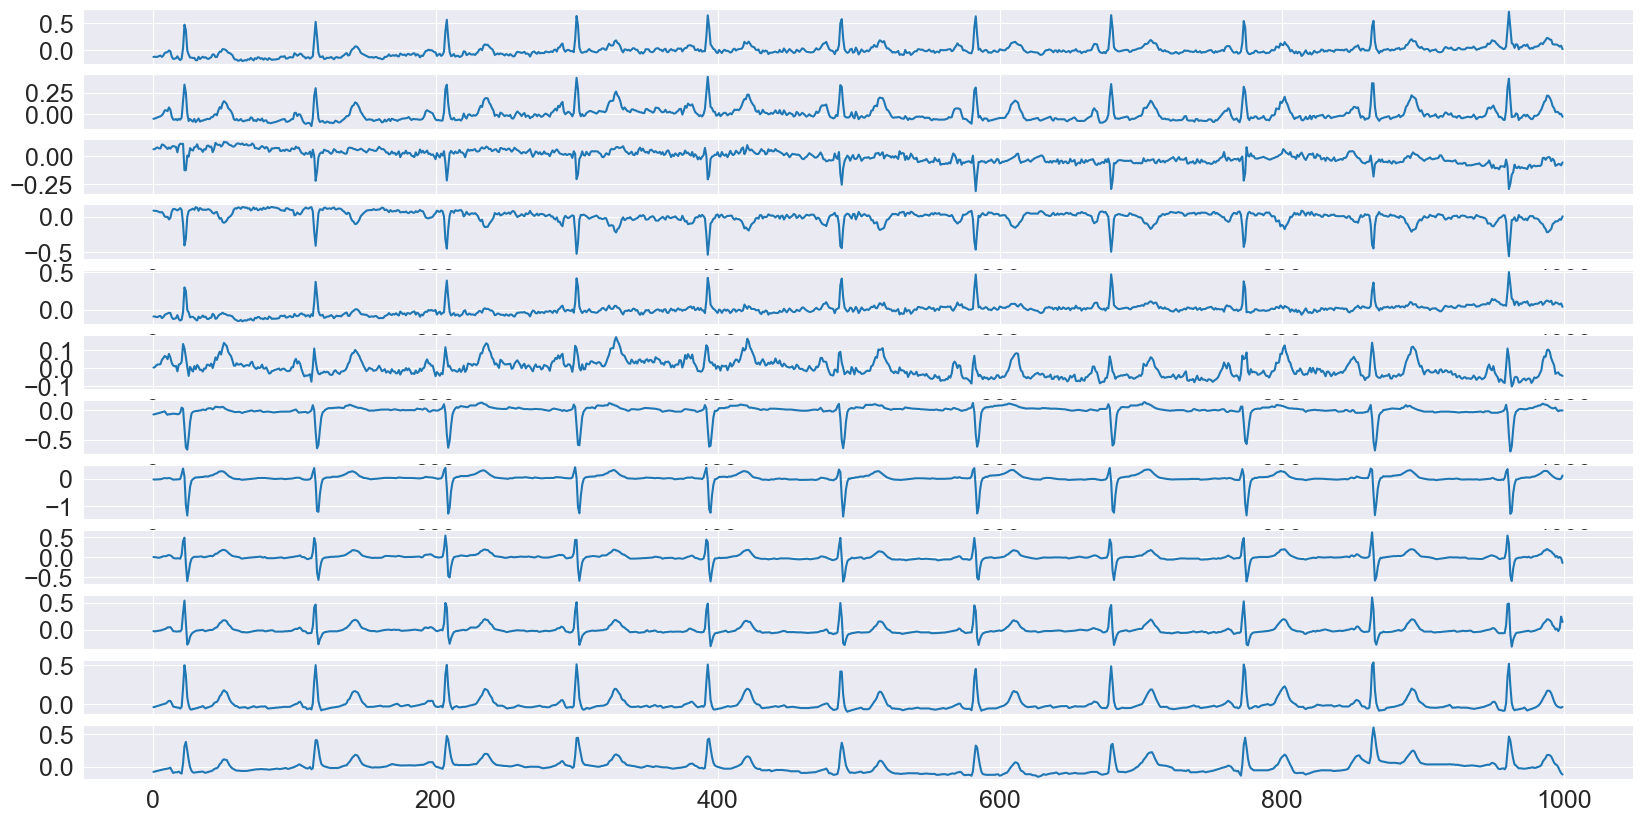

In [19]:
sample = ECG_data[0]  # Pastikan ECG_data sudah ada dalam lingkungan Anda
bar, axes = plt.subplots(sample.shape[1], 1, figsize=(20, 10))

for i in range(sample.shape[1]):
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])

# Perbesar angka pada sumbu X dan Y
for ax in axes:
    ax.tick_params(axis='both', labelsize=18)  # Mengatur ukuran font untuk sumbu X dan Y

plt.show()


And to add another angle of the view, there is an overview of unique values in all columns of metadata dataframe:

In [20]:
ECG_df[[col for col in ECG_df.columns if col not in ('scp_codes', 'scp_classes')]].nunique(dropna=True)

patient_id                      18885
age                                94
sex                                 2
height                             77
weight                            127
nurse                              12
site                               51
device                             11
recording_date                  21813
report                           9883
heart_axis                          8
infarction_stadium1                 6
infarction_stadium2                 3
validated_by                       12
second_opinion                      2
initial_autogenerated_report        2
validated_by_human                  2
baseline_drift                    321
static_noise                      124
burst_noise                       103
electrodes_problems                14
extra_beats                       128
pacemaker                           4
strat_fold                         10
filename_lr                     21837
filename_hr                     21837
dtype: int64

# Data preparation for modeling

## X dataframe (metadata)

In [21]:
X = pd.DataFrame(index=ECG_df.index)

X['age'] = ECG_df.age
X.age.fillna(0, inplace=True)

X['sex'] = ECG_df.sex.astype(float)
X.sex.fillna(0, inplace=True)

X['height'] = ECG_df.height
X.loc[X.height < 50, 'height'] = np.nan
X.height.fillna(0, inplace=True)

X['weight'] = ECG_df.weight
X.weight.fillna(0, inplace=True)

X['infarction_stadium1'] = ECG_df.infarction_stadium1.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium I-II': 2,
    'Stadium II': 3,
    'Stadium II-III': 4,
    'Stadium III': 5
}).fillna(0)

X['infarction_stadium2'] = ECG_df.infarction_stadium2.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium II': 2,
    'Stadium III': 3
}).fillna(0)

X['pacemaker'] = (ECG_df.pacemaker == 'ja, pacemaker').astype(float)

X

C:\Users\User\AppData\Local\Temp\ipykernel_21016\3316299910.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X.age.fillna(0, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_21016\3316299910.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[

,age,sex,height,weight,infarction_stadium1,infarction_stadium2,pacemaker
ecg_id,,,,,,,
1,56.0,1.0,0.0,63.0,0.0,0.0,0.0
2,19.0,0.0,0.0,70.0,0.0,0.0,0.0
3,37.0,1.0,0.0,69.0,0.0,0.0,0.0
4,24.0,0.0,0.0,82.0,0.0,0.0,0.0
5,19.0,1.0,0.0,70.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
21833,67.0,1.0,0.0,0.0,0.0,0.0,0.0
21834,93.0,0.0,0.0,0.0,4.0,0.0,0.0
21835,59.0,1.0,0.0,0.0,0.0,0.0,0.0


## Y dataframe (raw signal)



## Z targets (target)

In [22]:
Z = pd.DataFrame(0, index=ECG_df.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    for k in ECG_df.loc[i].scp_classes:
        Z.loc[i, k] = 1

Z

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
...,...,...,...,...,...
21833,0,0,1,0,0
21834,1,0,0,0,0
21835,0,0,1,0,0


## Splitting to train, validate and test datasets

As the authors of PTB-XL ECG dataset suggest, I will split all input and output dataset to training, validation and test subsets according *strat_fold* column.

In [23]:
from sklearn.model_selection import train_test_split
X_train, Y_train, Z_train = X[ECG_df.strat_fold <= 10],  ECG_data[X[ECG_df.strat_fold <= 10].index - 1],  Z[ECG_df.strat_fold <= 10]

# mask_train = (Z_train['NORM'] == 1) | (Z_train['MI'] == 1)
# X_train_filtered = X_train[mask_train]
# Y_train_filtered = Y_train[mask_train]
# Z_train_filtered = Z_train[mask_train].drop(columns=['STTC', 'CD', 'HYP'])

# X_train_full, X_test, Y_train_full, Y_test, Z_train_full, Z_test = train_test_split(
#     X_train_filtered, Y_train_filtered, Z_train_filtered, test_size=0.1, random_state=42
# )

X_train_full, X_test, Y_train_full, Y_test, Z_train_full, Z_test = train_test_split(
    X_train, Y_train, Z_train, test_size=0.1, random_state=42
)

# Split lagi data training menjadi 80% train dan 20% validation
X_train, X_valid, Y_train, Y_valid, Z_train, Z_valid = train_test_split(
    X_train_full, Y_train_full, Z_train_full, test_size=0.2, random_state=42
)

print(X_train.shape, Y_train.shape, Z_train.shape)
print(X_valid.shape, Y_valid.shape, Z_valid.shape)
print(X_test.shape,  Y_test.shape,  Z_test.shape)

(15722, 7) (15722, 1000, 12) (15722, 5)
(3931, 7) (3931, 1000, 12) (3931, 5)
(2184, 7) (2184, 1000, 12) (2184, 5)


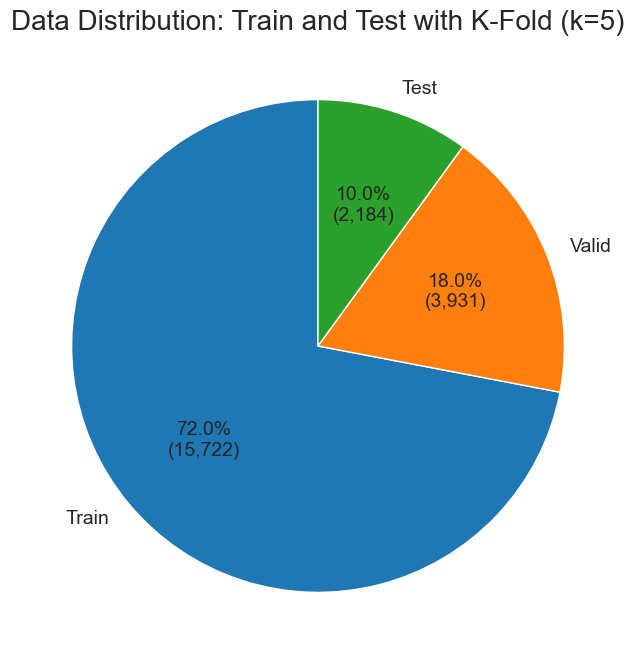

In [25]:
import matplotlib.pyplot as plt

# Example data sizes (replace with actual sizes from your data)
train_size = X_train.shape[0]  # replace with X_train.shape[0]
valid_size = X_valid.shape[0]  # replace with X_valid.shape[0]
test_size = X_test.shape[0]   # replace with X_test.shape[0]

# Sizes of each dataset
sizes = [train_size, valid_size,test_size]
labels = ['Train','Valid', 'Test']

def autopct_with_values(pct, all_values):
    absolute = int(round(pct / 100. * sum(all_values)))
    return f"{pct:.1f}%\n({absolute:,})"

plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct=lambda pct: autopct_with_values(pct, sizes),
    startangle=90,
    textprops={'fontsize': 14}
)
plt.title('Data Distribution: Train and Test with K-Fold (k=5)', fontsize=20)
plt.show()

## Standardization of all input datasets

Wise people sometimes recommend to normalize/standardize data before using them for modeling and predictions. I will obey their opinions.

In [26]:
from sklearn.preprocessing import StandardScaler

# Step 1: Initialize the scaler
X_scaler = StandardScaler()

# Step 2: Fit the scaler only on the X_train data
X_scaler.fit(X_train)

# Step 3: Transform the training, validation, and test sets using the fitted scaler
X_train_scaled = pd.DataFrame(X_scaler.transform(X_train), columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_scaler.transform(X_valid), columns=X_valid.columns)
X_test_scaled  = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns)

# Check the shapes to ensure everything is scaled correctly
print("Scaled Train shape:", X_train_scaled.shape)
print("Scaled Validation shape:", X_valid_scaled.shape)
print("Scaled Test shape:", X_test_scaled.shape)


Scaled Train shape: (15722, 7)
Scaled Validation shape: (3931, 7)
Scaled Test shape: (2184, 7)


In [27]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler for Y data
Y_scaler = StandardScaler()

# Step 1: Fit the scaler only on the Y_train data
Y_scaler.fit(Y_train.reshape(-1, Y_train.shape[-1]))

# Step 2: Transform the training, validation, and test sets
Y_train_scaled = Y_scaler.transform(Y_train.reshape(-1, Y_train.shape[-1])).reshape(Y_train.shape)
Y_valid_scaled = Y_scaler.transform(Y_valid.reshape(-1, Y_valid.shape[-1])).reshape(Y_valid.shape)
Y_test_scaled  = Y_scaler.transform(Y_test.reshape(-1, Y_test.shape[-1])).reshape(Y_test.shape)

# Check the shapes to ensure everything is scaled correctly
print("Scaled Train Y shape:", Y_train_scaled.shape)
print("Scaled Validation Y shape:", Y_valid_scaled.shape)
print("Scaled Test Y shape:", Y_test_scaled.shape)


Scaled Train Y shape: (15722, 1000, 12)
Scaled Validation Y shape: (3931, 1000, 12)
Scaled Test Y shape: (2184, 1000, 12)


In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Prepare data
# Ensure the input is 3D (samples, timesteps, features) for LSTM
X_train = Y_train_scaled  # Using the signal data as X
X_valid = Y_valid_scaled
X_test  = Y_test_scaled

# Z is the target (NORM, MI)
# y_train = Z_train[['NORM', 'MI']].values
# y_valid = Z_valid[['NORM', 'MI']].values
# y_test  = Z_test[['NORM', 'MI']].values

y_train = Z_train
y_valid = Z_valid
y_test  = Z_test


print("Train beats :", X_train.shape, y_train.shape)
print("Valid beats :", X_valid.shape, y_valid.shape)
print("Test beats  :", X_test.shape, y_test.shape)

Train beats : (15722, 1000, 12) (15722, 5)
Valid beats : (3931, 1000, 12) (3931, 5)
Test beats  : (2184, 1000, 12) (2184, 5)


# LSTM


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6726 - loss: 0.6593
Epoch 1: val_accuracy improved from -inf to 0.68960, saving model to modelResult/best_lstm_model.keras
342/342 ━━━━━━━━━━━━━━━━━━━━ 53s 151ms/step - accuracy: 0.6726 - loss: 0.6592 - val_accuracy: 0.6896 - val_loss: 0.6229 - learning_rate: 0.0010
Epoch 2/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6844 - loss: 0.6274
Epoch 2: val_accuracy did not improve from 0.68960
342/342 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - accuracy: 0.6844 - loss: 0.6274 - val_accuracy: 0.6896 - val_loss: 0.6207 - learning_rate: 0.0010
Epoch 3/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6777 - loss: 0.6228
Epoch 3: val_accuracy did not improve from 0.68960
342/342 ━━━━━━━━━━━━━━━━━━━━ 49s 143ms/step - accuracy: 0.6777 - loss: 0.6228 - val_accuracy: 0.6896 - val_loss: 0.5949 - learning_rate: 0.0010
Epoch 4/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6744 - loss: 0.6035
Epoch 4: va

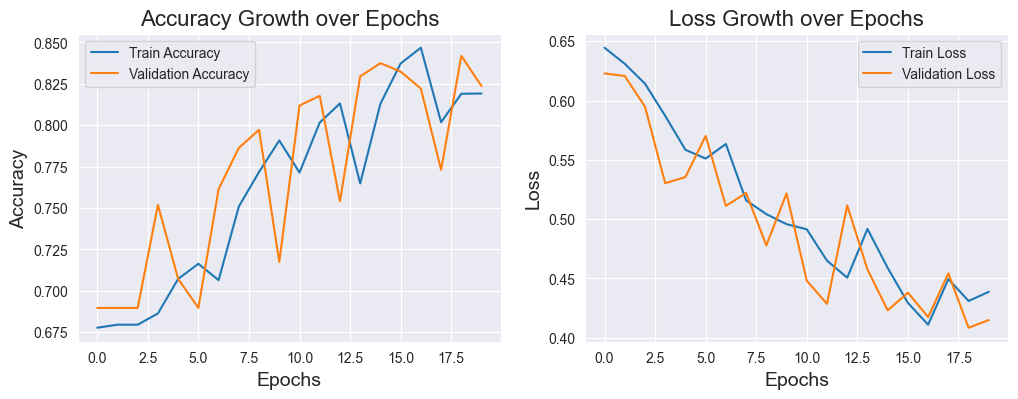

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8235 - loss: 0.4363


Test Loss: 0.4314582049846649, Test Accuracy: 0.8234519362449646
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


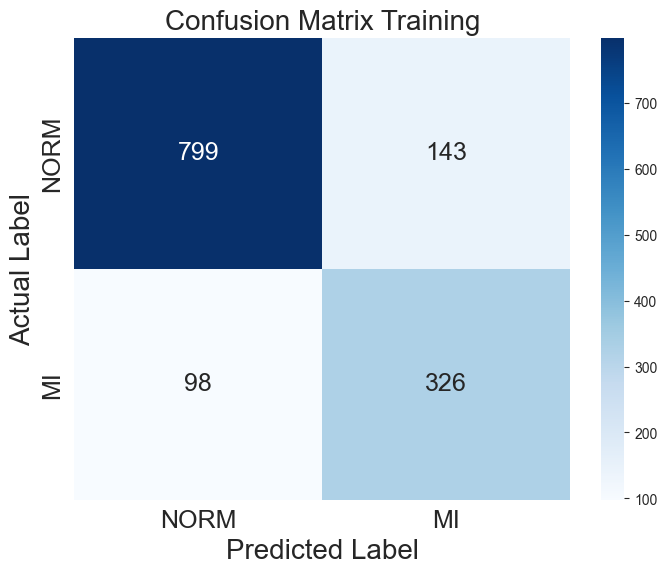

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


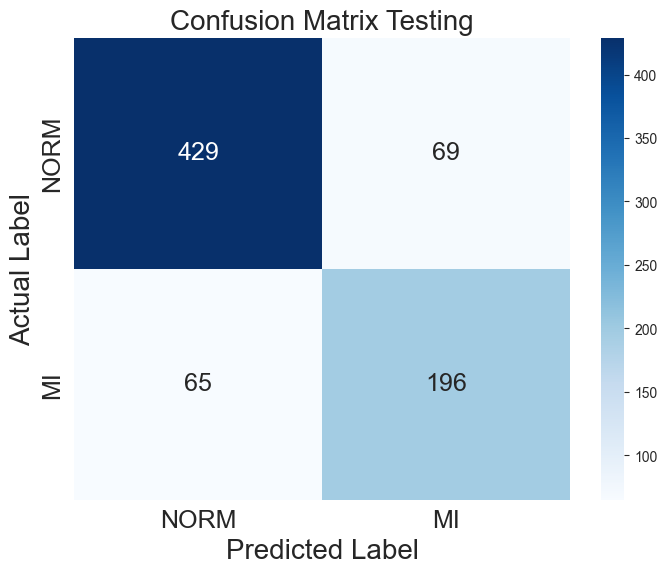

In [18]:
# Define the LSTM model
model_lstm = Sequential()

# LSTM layer with 50 units
model_lstm.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Dropout to prevent overfitting
model_lstm.add(Dropout(0.2))

# Fully connected layer with softmax for binary classification
model_lstm.add(Dense(32, activation='softmax'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks

# Save the best model during training
checkpoint = ModelCheckpoint(filepath='modelResult/best_lstm_model.keras', 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             verbose=1, 
                             mode='max')

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.000, 
                              verbose=1)

# Train the model with callbacks
history = model_lstm.fit(X_train, y_train, 
                         epochs=20, 
                         batch_size=16, 
                         validation_data=(X_valid, y_valid),
                         callbacks=[checkpoint, reduce_lr], 
                         verbose=1)

# Plot the accuracy and loss growth graph
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Growth over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Growth over Epochs' , fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.savefig('image/training_history_lstm.png')
plt.show()

# Evaluate on the test set
test_loss, test_accuracy = model_lstm.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# ave the final model and training history
model_lstm.save('modelResult/final_lstm_model.h5')  # Save the final model

# Save history to CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv('excel_output/training_history_lstm.csv', index=False)

# Confusion Matrix
# Predict on the val set
y_pred = model_lstm.predict(X_valid)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_valid, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
labels = ['NORM', 'MI']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
plt.title('Confusion Matrix Training', fontsize=20)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('Actual Label', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('image/confusion_matrix_train_lstm.png', dpi=300)
plt.show()

# Step 9: Save confusion matrix to file
# Save confusion matrix as CSV
cm_df = pd.DataFrame(cm, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
cm_df.to_csv('excel_output/confusion_matrix_train_lstm.csv')



# Predict on the test set
y_pred = model_lstm.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
labels = ['NORM', 'MI']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
plt.title('Confusion Matrix Testing', fontsize=20)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('Actual Label', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('image/confusion_matrix_train_lstm.png', dpi=300)
plt.show()

# Step 9: Save confusion matrix to file
# Save confusion matrix as CSV
cm_df = pd.DataFrame(cm, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
cm_df.to_csv('excel_output/confusion_matrix_test_lstm.csv')




# STACKED LSTM


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
983/983 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.3197 - loss: 3.1841
Epoch 1: val_accuracy improved from -inf to 0.17858, saving model to modelResult/best_stacked_lstm_model.keras
983/983 ━━━━━━━━━━━━━━━━━━━━ 251s 254ms/step - accuracy: 0.3197 - loss: 3.1848 - val_accuracy: 0.1786 - val_loss: 2.9311 - learning_rate: 0.0010
Epoch 2/20
983/983 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.2852 - loss: 2.7868
Epoch 2: val_accuracy improved from 0.17858 to 0.45739, saving model to modelResult/best_stacked_lstm_model.keras
983/983 ━━━━━━━━━━━━━━━━━━━━ 266s 270ms/step - accuracy: 0.2852 - loss: 2.7867 - val_accuracy: 0.4574 - val_loss: 3.1544 - learning_rate: 0.0010
Epoch 3/20
983/983 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.2938 - loss: 2.8499
Epoch 3: val_accuracy did not improve from 0.45739
983/983 ━━━━━━━━━━━━━━━━━━━━ 235s 239ms/step - accuracy: 0.2938 - loss: 2.8500 - val_accuracy: 0.1786 - val_loss: 2.6314 - learning_rate: 0.0010
Epoch 4/20
983/983 ━━━━━━

FileNotFoundError: [Errno 2] No such file or directory: 'image/training_history_stacked_lstm.png'

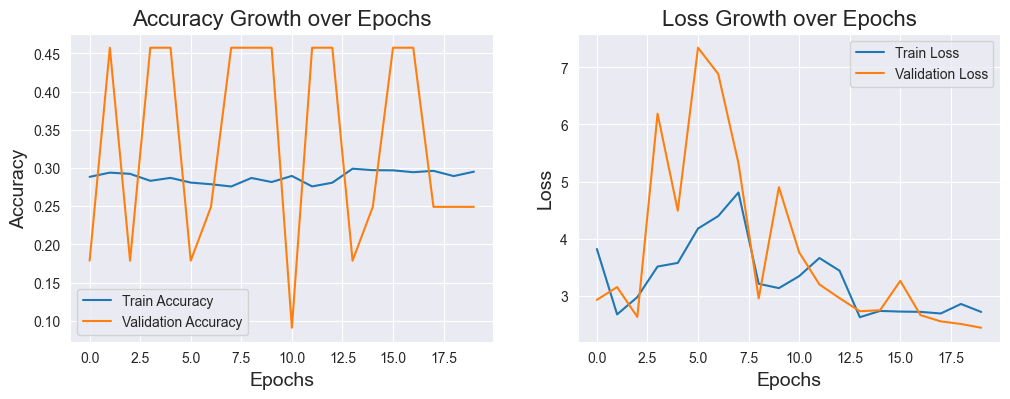

In [31]:
# Define the Stacked LSTM model
model_stacked_lstm = Sequential()

# First LSTM layer with 100 units, return sequences for stacking
model_stacked_lstm.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_stacked_lstm.add(Dropout(0.3))

# Second LSTM layer with 50 units, no return sequences
model_stacked_lstm.add(LSTM(50, return_sequences=False))
model_stacked_lstm.add(Dropout(0.3))

# Fully connected layer with ReLU activation
model_stacked_lstm.add(Dense(64, activation='relu'))
model_stacked_lstm.add(Dropout(0.2))

# Output layer with softmax for binary classification
model_stacked_lstm.add(Dense(5, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_stacked_lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks

# Save the best model during training
checkpoint = ModelCheckpoint(filepath='modelResult/best_stacked_lstm_model.keras', 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             verbose=1, 
                             mode='max')

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.000, 
                              verbose=1)

# Train the model with callbacks
history = model_stacked_lstm.fit(X_train, y_train, 
                                 epochs=20, 
                                 batch_size=16, 
                                 validation_data=(X_valid, y_valid),
                                 callbacks=[checkpoint, reduce_lr], 
                                 verbose=1)

# Plot the accuracy and loss growth graph
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Growth over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Growth over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.savefig('image/training_history_stacked_lstm.png')
plt.show()

# Evaluate on the test set
test_loss, test_accuracy = model_stacked_lstm.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the final model and training history
model_stacked_lstm.save('modelResult/final_stacked_lstm_model.h5')  # Save the final model

# Save history to CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv('excel_output/training_history_stacked_lstm.csv', index=False)

# Confusion Matrix
# Predict on the val set
y_pred = model_stacked_lstm.predict(X_valid)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_valid, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
labels = ['NORM', 'MI']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
plt.title('Confusion Matrix Training', fontsize=20)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('Actual Label', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('image/confusion_matrix_train_stacked_lstm.png', dpi=300)
plt.show()

# Save confusion matrix as CSV
cm_df = pd.DataFrame(cm, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
cm_df.to_csv('excel_output/confusion_matrix_train_stacked_lstm.csv')

# Predict on the test set
y_pred = model_stacked_lstm.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
labels = ['NORM', 'MI']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
plt.title('Confusion Matrix Testing', fontsize=20)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('Actual Label', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('image/confusion_matrix_test_stacked_lstm.png', dpi=300)
plt.show()

# Save confusion matrix as CSV
cm_df = pd.DataFrame(cm, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
cm_df.to_csv('excel_output/confusion_matrix_test_stacked_lstm.csv')


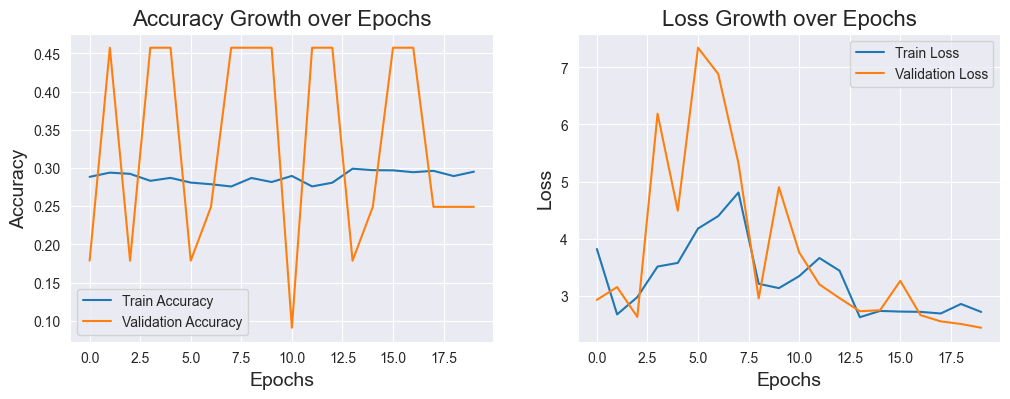

69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.2588 - loss: 2.3444


Test Loss: 2.3806209564208984, Test Accuracy: 0.25732600688934326
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step


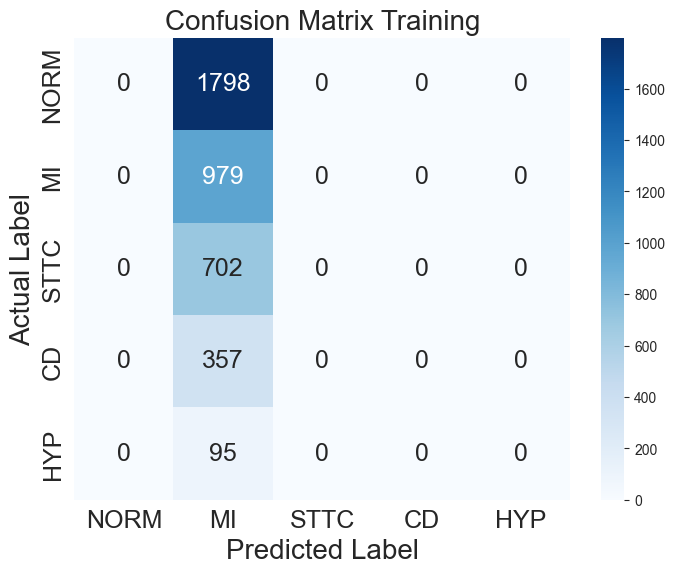

ValueError: Shape of passed values is (5, 5), indices imply (5, 2)

In [33]:
# Plot the accuracy and loss growth graph
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Growth over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Growth over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.savefig('image/training_history_stacked_lstm.png')
plt.show()

# Evaluate on the test set
test_loss, test_accuracy = model_stacked_lstm.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the final model and training history
model_stacked_lstm.save('modelResult/final_stacked_lstm_model.h5')  # Save the final model

# Save history to CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv('excel_output/training_history_stacked_lstm.csv', index=False)

# Confusion Matrix
# Predict on the val set
y_pred = model_stacked_lstm.predict(X_valid)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_valid, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
labels = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
plt.title('Confusion Matrix Training', fontsize=20)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('Actual Label', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('image/confusion_matrix_train_stacked_lstm.png', dpi=300)
plt.show()

# Save confusion matrix as CSV
cm_df = pd.DataFrame(cm, index=['NORM', 'MI', 'STTC', 'CD', 'HYP'], columns=['Predicted NORM', 'Predicted MI'])
cm_df.to_csv('excel_output/confusion_matrix_train_stacked_lstm.csv')

# Predict on the test set
y_pred = model_stacked_lstm.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
labels = ['NORM', 'MI']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
plt.title('Confusion Matrix Testing', fontsize=20)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('Actual Label', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('image/confusion_matrix_test_stacked_lstm.png', dpi=300)
plt.show()

# Save confusion matrix as CSV
cm_df = pd.DataFrame(cm, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
cm_df.to_csv('excel_output/confusion_matrix_test_stacked_lstm.csv')





# BI LSTM


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.6654 - loss: 0.6192
Epoch 1: val_accuracy improved from -inf to 0.77233, saving model to modelResult/best_bi_lstm_model.keras
342/342 ━━━━━━━━━━━━━━━━━━━━ 225s 644ms/step - accuracy: 0.6656 - loss: 0.6191 - val_accuracy: 0.7723 - val_loss: 0.5069 - learning_rate: 0.0010
Epoch 2/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.7533 - loss: 0.5413
Epoch 2: val_accuracy improved from 0.77233 to 0.78624, saving model to modelResult/best_bi_lstm_model.keras
342/342 ━━━━━━━━━━━━━━━━━━━━ 222s 648ms/step - accuracy: 0.7533 - loss: 0.5412 - val_accuracy: 0.7862 - val_loss: 0.4554 - learning_rate: 0.0010
Epoch 3/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.7682 - loss: 0.5057
Epoch 3: val_accuracy did not improve from 0.78624
342/342 ━━━━━━━━━━━━━━━━━━━━ 213s 621ms/step - accuracy: 0.7681 - loss: 0.5058 - val_accuracy: 0.7526 - val_loss: 0.5431 - learning_rate: 0.0010
Epoch 4/20
342/342 ━━━━━━━━━━━━━━━━

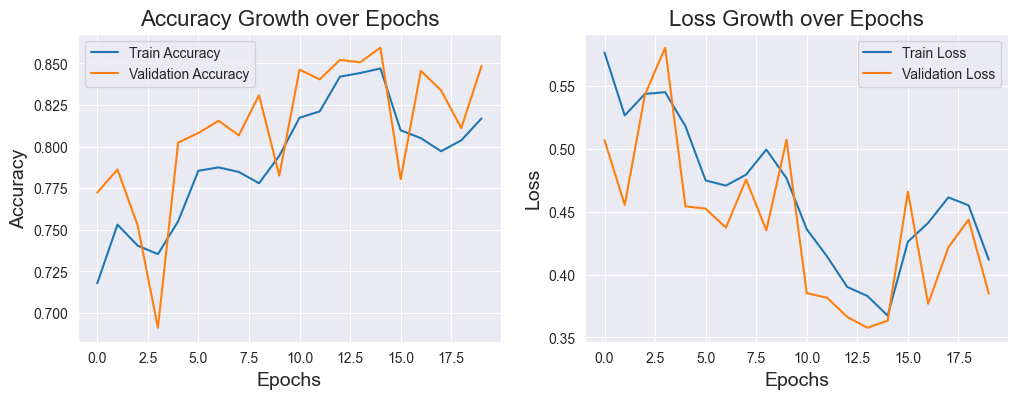

24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 331ms/step - accuracy: 0.8602 - loss: 0.3689


Test Loss: 0.3895019292831421, Test Accuracy: 0.8418972492218018
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 308ms/step


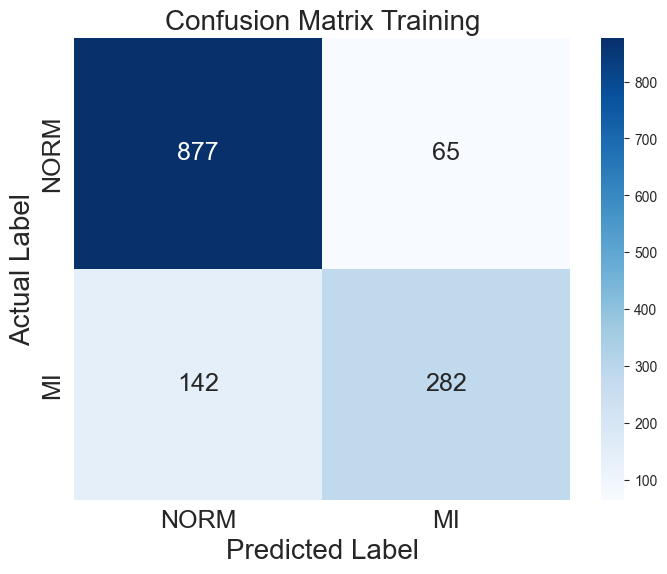

24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 312ms/step


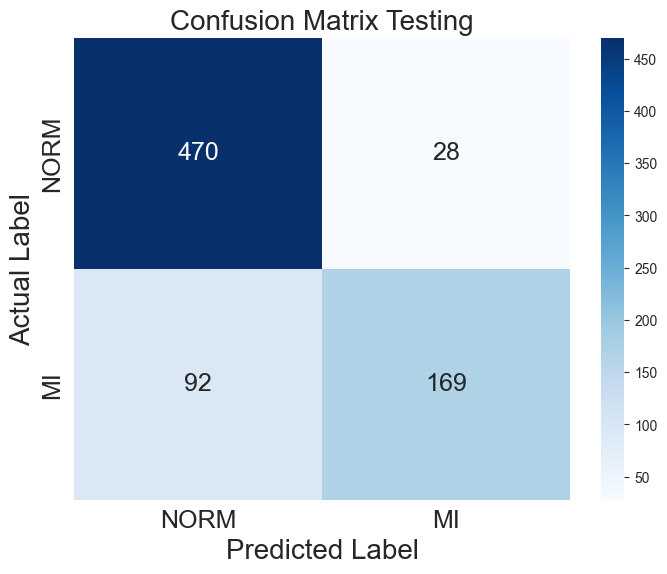

In [21]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

# Define the Bi-directional LSTM model
model_bi_lstm = Sequential()

# Add Bidirectional LSTM layers and Dropout
model_bi_lstm.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model_bi_lstm.add(Dropout(0.3))

model_bi_lstm.add(Bidirectional(LSTM(50, return_sequences=False)))
model_bi_lstm.add(Dropout(0.3))

# Fully connected layers
model_bi_lstm.add(Dense(64, activation='relu'))
model_bi_lstm.add(Dropout(0.2))

# Output layer
model_bi_lstm.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_bi_lstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks

# Save the best model during training
checkpoint = ModelCheckpoint(filepath='modelResult/best_bi_lstm_model.keras', 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             verbose=1, 
                             mode='max')

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.000, 
                              verbose=1)

# Train the model with callbacks
history = model_bi_lstm.fit(X_train, y_train, 
                            epochs=20, 
                            batch_size=16, 
                            validation_data=(X_valid, y_valid),
                            callbacks=[checkpoint, reduce_lr], 
                            verbose=1)

# Plot the accuracy and loss growth graph
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Growth over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Growth over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.savefig('image/training_history_bi_lstm.png')
plt.show()

# Evaluate on the test set
test_loss, test_accuracy = model_bi_lstm.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the final model and training history
model_bi_lstm.save('modelResult/final_bi_lstm_model.h5')  # Save the final model

# Save history to CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv('excel_output/training_history_bi_lstm.csv', index=False)

# Confusion Matrix
# Predict on the val set
y_pred = model_bi_lstm.predict(X_valid)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_valid, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
labels = ['NORM', 'MI']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
plt.title('Confusion Matrix Training', fontsize=20)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('Actual Label', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('image/confusion_matrix_train_bi_lstm.png', dpi=300)
plt.show()

# Save confusion matrix as CSV
cm_df = pd.DataFrame(cm, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
cm_df.to_csv('excel_output/confusion_matrix_train_bi_lstm.csv')

# Predict on the test set
y_pred = model_bi_lstm.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
labels = ['NORM', 'MI']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
plt.title('Confusion Matrix Testing', fontsize=20)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('Actual Label', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('image/confusion_matrix_test_bi_lstm.png', dpi=300)
plt.show()

# Save confusion matrix as CSV
cm_df = pd.DataFrame(cm, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
cm_df.to_csv('excel_output/confusion_matrix_test_bi_lstm.csv')


# END